<img src="https://www.ucnj.com/_Content/img/pages-covers/transportation.jpg">

# preprocessing

In [1]:
pip install fitter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25609 sha256=64708b1f460ae347fba9312714dd8874f492f2e26493fd6f8c90c9c9d96dd797
  Stored in directory: /root/.cache/pip/wheels/8e/6b/cb/628035771acab95dc84f200590b4838c7c3095a70ede67a25a
Successfully built fitter


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from fitter import Fitter, get_common_distributions, get_distributions
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import io
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind
from google.colab import files


In [3]:

uploaded=files.upload()

Saving q1final.csv to q1final.csv


In [4]:
df = pd.read_csv(io.BytesIO(uploaded['q1final.csv']))
#if use jupiter notbook please read file with next code line
#df=pd.read_csv('C:/Users/shayan9776/Desktop/tp_proj/q1final.csv')

df.head()

,price_check_time,passenger,origin,destination,price,subsidy,distance,expected_duration,req_time,driver,status
0,1/4/2021 0:00,0,0,0,70000,0,4174.0,8.0,NaN,NaN,NaN
1,1/6/2021 12:11,10,0,0,60000,10000,2851.0,8.0,NaN,NaN,NaN
2,1/3/2021 20:15,15,0,0,65000,10000,4386.0,8.0,NaN,NaN,NaN
3,1/3/2021 20:11,15,0,0,75000,10000,4488.0,9.0,NaN,NaN,NaN
4,1/4/2021 14:46,22,0,0,75000,10000,3683.0,8.0,NaN,NaN,NaN


In [5]:
# counting NaN values of col1
cnt = df.isna().sum()/df.shape[0]
  
# printing count of NaN values
print("\nNan values in col1:", cnt)


Nan values in col1: price_check_time     0.000000
passenger            0.000000
origin               0.000000
destination          0.000000
price                0.000000
subsidy              0.000000
distance             0.009750
expected_duration    0.010087
req_time             0.375486
driver               0.461932
status               0.375486
dtype: float64


In [6]:
df.shape

(26768, 11)

### null controller

In [7]:

df_1 = df[df['distance'].notnull()]
df_2 = df_1[df_1['expected_duration'].notnull()]
# To reset the indices
df_2 = df_2.reset_index()
df_2.drop(['index'], axis = 1, inplace = True) 
# Convert string to datetime64
df_2["price_check_time"] = df_2["price_check_time"].apply(pd.to_datetime)
df_2.set_index('price_check_time',inplace=True)
df_2.head()


,passenger,origin,destination,price,subsidy,distance,expected_duration,req_time,driver,status
price_check_time,,,,,,,,,,
2021-01-04 00:00:00,0,0,0,70000,0,4174.0,8.0,NaN,NaN,NaN
2021-01-06 12:11:00,10,0,0,60000,10000,2851.0,8.0,NaN,NaN,NaN
2021-01-03 20:15:00,15,0,0,65000,10000,4386.0,8.0,NaN,NaN,NaN
2021-01-03 20:11:00,15,0,0,75000,10000,4488.0,9.0,NaN,NaN,NaN
2021-01-04 14:46:00,22,0,0,75000,10000,3683.0,8.0,NaN,NaN,NaN


In [8]:
df_2.isna().sum()

passenger                0
origin                   0
destination              0
price                    0
subsidy                  0
distance                 0
expected_duration        0
req_time              9850
driver               12120
status                9850
dtype: int64

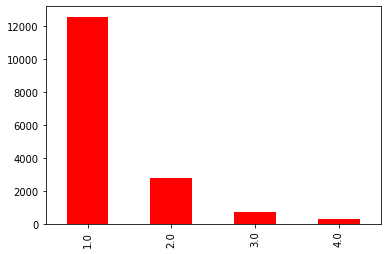

In [11]:
x = df_2['status'].value_counts().plot(kind='bar', color='red')


In [12]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26243 entries, 2021-01-04 00:00:00 to 2021-01-05 20:05:00
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   passenger          26243 non-null  int64  
 1   origin             26243 non-null  int64  
 2   destination        26243 non-null  int64  
 3   price              26243 non-null  int64  
 4   subsidy            26243 non-null  int64  
 5   distance           26243 non-null  float64
 6   expected_duration  26243 non-null  float64
 7   req_time           16393 non-null  object 
 8   driver             14123 non-null  float64
 9   status             16393 non-null  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 2.2+ MB


### EDA

we want delete outliers points

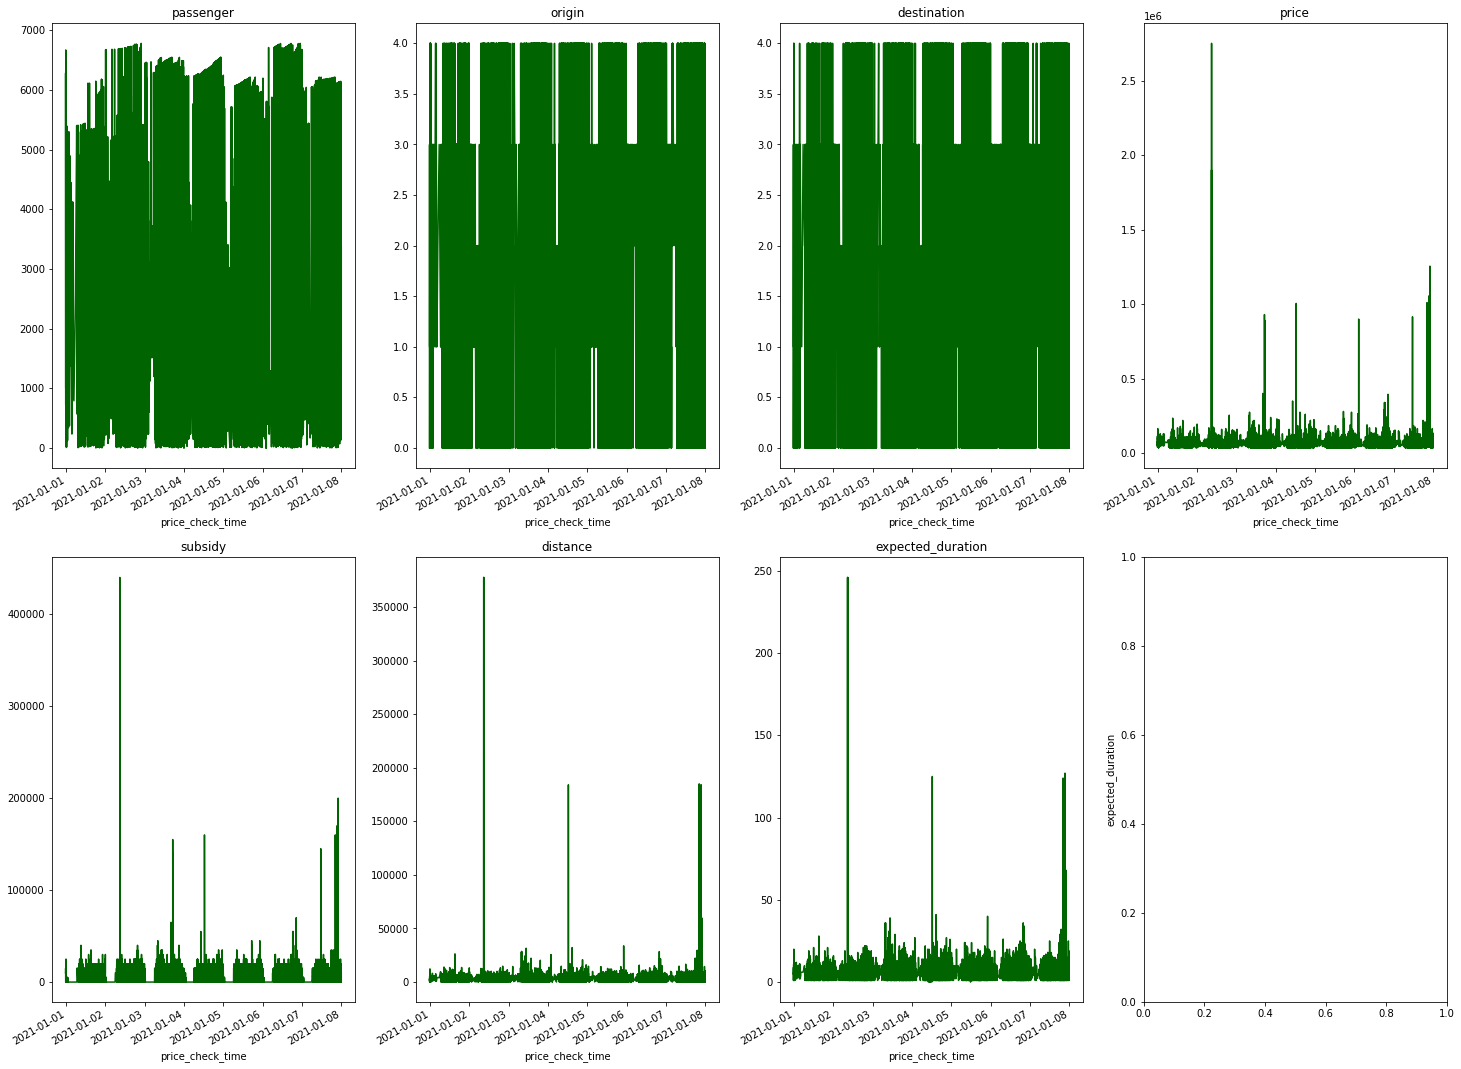

In [13]:
def sub_plot(df, nrow = 2, ncol = 4):

    fig, axes = plt.subplots(nrow, ncol)

    # plot counter
    count = 0
    breaker = False
    for r in range(nrow):
        for c in range(ncol):
            df[df.columns[count]].plot(figsize=(25,20),color='darkgreen',title=df.columns[count],ax=axes[r,c])
            plt.ylabel(df.columns[count])
            count+=1


            if df_2.columns[count] =='req_time':
                breaker = True 
                break
        if breaker: # the interesting part!
            break   # <--- !
sub_plot(df_2)

In [14]:
def remove_outliers(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df

df_3 = remove_outliers(df_2,df_2.columns[0:7],6)

Working on column: passenger
Working on column: origin
Working on column: destination
Working on column: price
Working on column: subsidy
Working on column: distance
Working on column: expected_duration


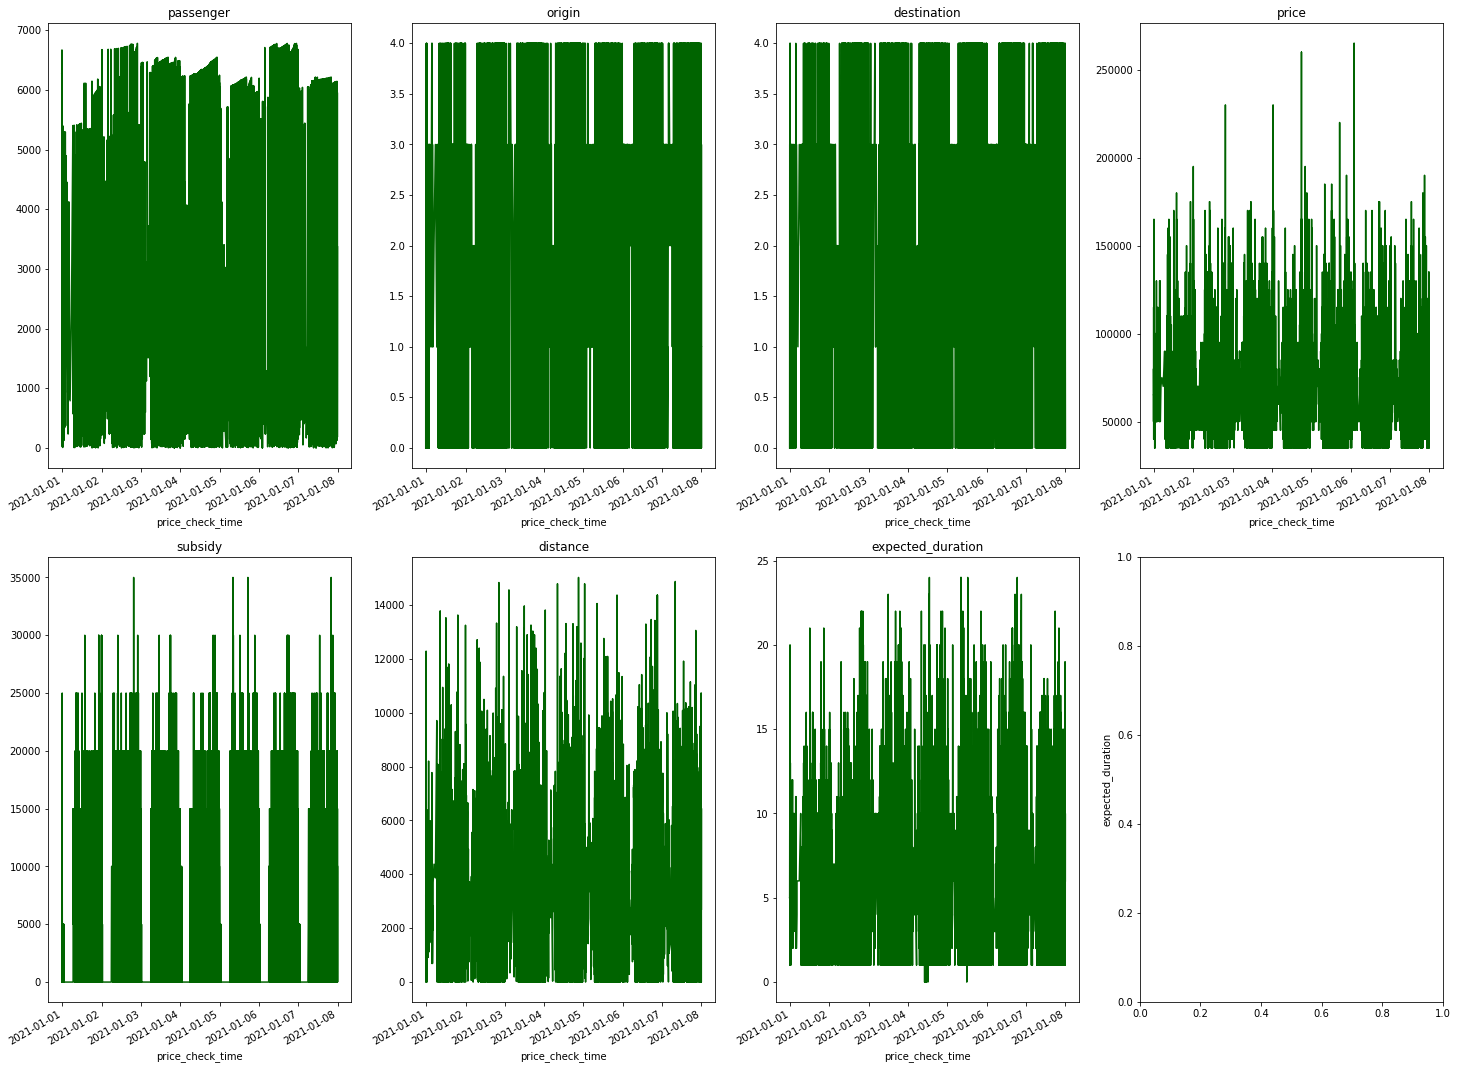

In [15]:
sub_plot(df_3)

### Time-series seasonal decomposition(optional)

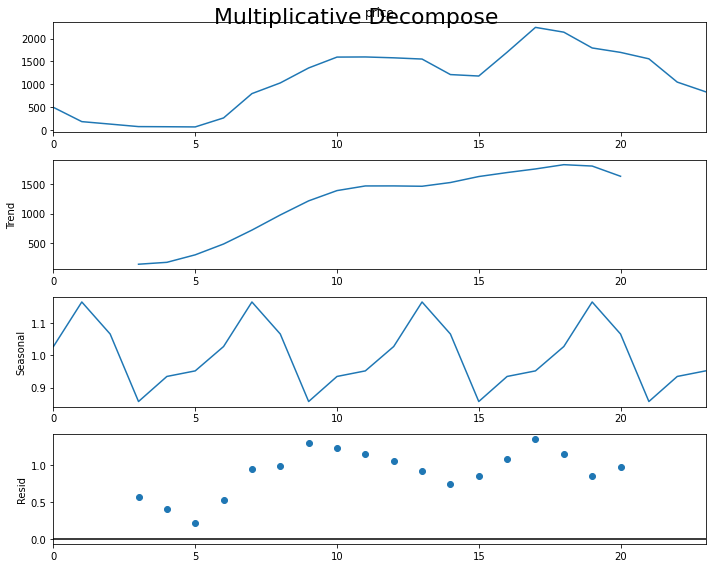

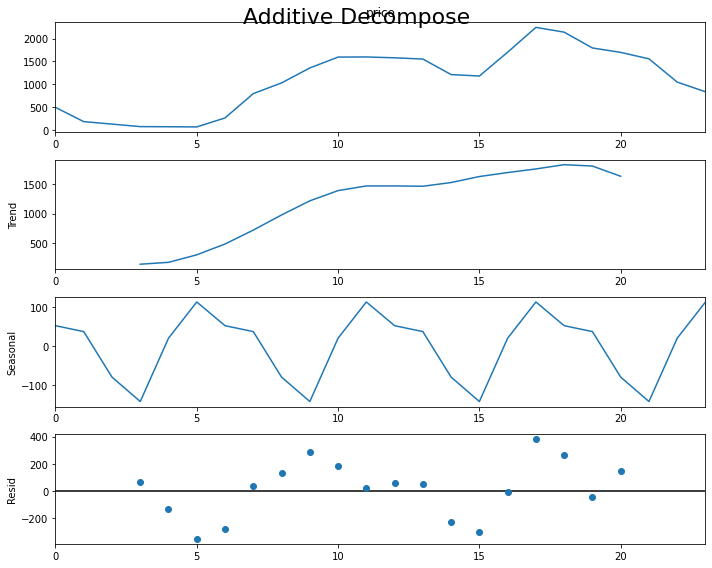

In [51]:

plt.rcParams.update({'figure.figsize': (10,10)})
y = df_3.groupby([df_3.index.hour]).price.count()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 6)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 6)

# Plot
plt.rcParams.update({'figure.figsize': (10,8)})

result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22 )
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

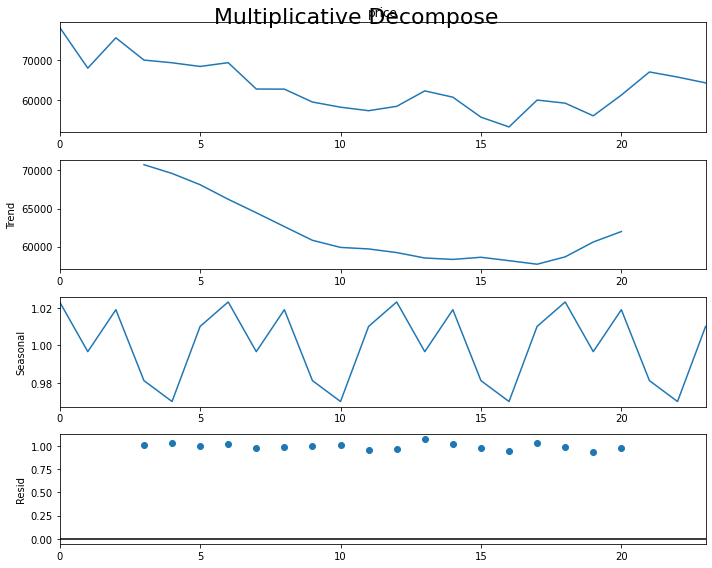

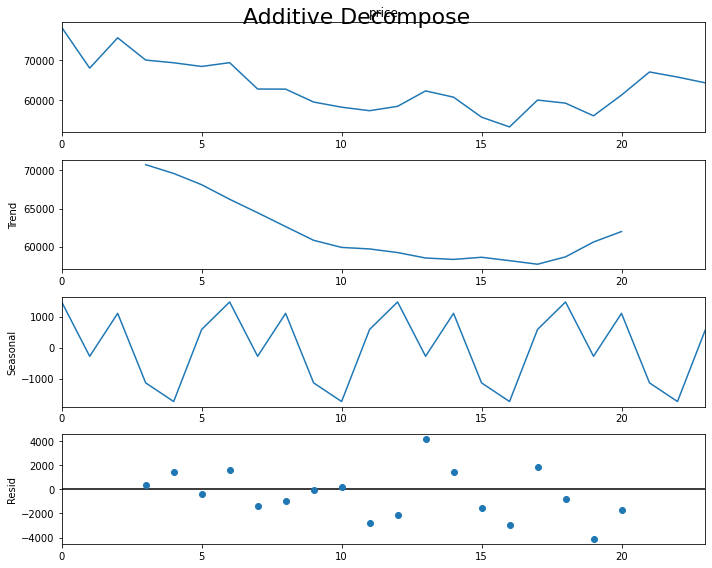

In [17]:
plt.rcParams.update({'figure.figsize': (10,10)})
y = df_3.groupby([df_3.index.hour]).price.mean()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 6)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 6)

# Plot
plt.rcParams.update({'figure.figsize': (10,8)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

conclusion for time series decomposition: we have a upward trend for counts of trips in douring day and downward trend for price in douring day.

# OD

2)

od matrix: 


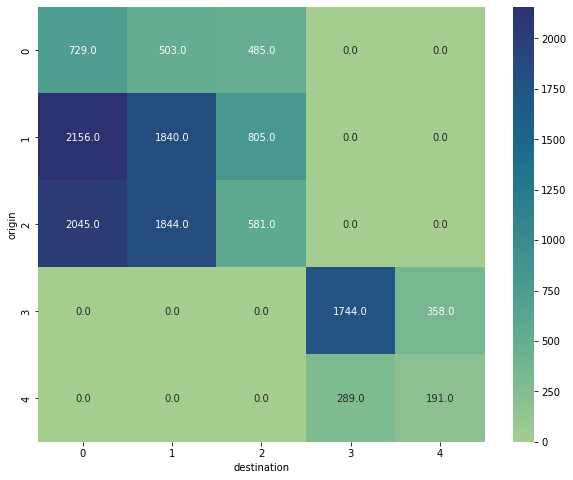

In [18]:
temp_OD = pd.DataFrame([df_3[(df_3.status == 1)|(df_3.status == 3)|(df_3.status == 4)].reset_index().destination,
                        df_3[(df_3.status == 1)|(df_3.status == 3)|(df_3.status == 4)].reset_index().origin])
df_od = pd.pivot_table(temp_OD.transpose(), values='destination', index=['origin'],
                    columns=['destination'], fill_value=0, aggfunc=len)
print('od matrix: ')
df_od
sns.heatmap(df_od, annot = True,fmt=".1f", cmap="crest")

3)

In [19]:
df_3[df_3['status'] ==1]

,passenger,origin,destination,price,subsidy,distance,expected_duration,req_time,driver,status
price_check_time,,,,,,,,,,
2021-01-02 17:18:00,6747,0,0,65000,10000,3608.0,7.0,1/2/2021 17:23,1.0,1.0
2021-01-03 23:53:00,0,0,0,55000,10000,4155.0,8.0,1/4/2021 0:02,2.0,1.0
2021-01-04 07:59:00,1077,0,0,70000,10000,6526.0,10.0,1/4/2021 8:01,2.0,1.0
2021-01-05 10:12:00,1740,0,0,50000,10000,3088.0,7.0,1/5/2021 10:13,2.0,1.0
2021-01-07 19:35:00,4759,0,0,45000,5000,1628.0,6.0,1/7/2021 19:43,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2021-01-07 10:19:00,3547,4,4,35000,10000,1258.0,2.0,1/7/2021 10:21,1642.0,1.0
2021-01-03 16:26:00,4478,4,4,35000,0,154.0,1.0,1/3/2021 16:34,1649.0,1.0
2021-01-06 17:29:00,4333,4,4,45000,10000,1088.0,3.0,1/6/2021 17:33,1676.0,1.0


od matrix for done trips: 


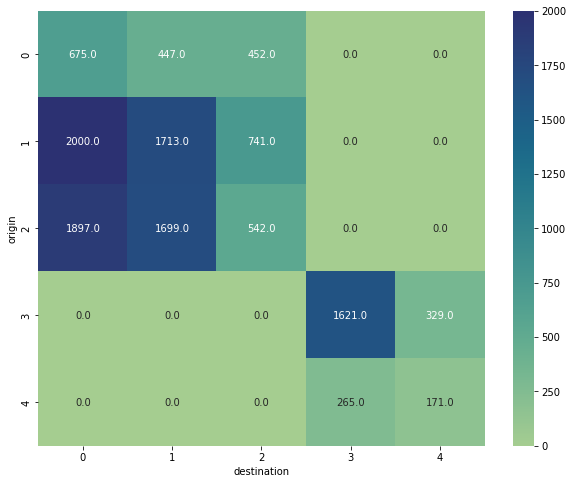

In [20]:
temp_OD = pd.DataFrame([df_3[df_3['status'] ==1].reset_index().destination, 
                        df_3[df_3['status'] ==1].reset_index().origin])

df_od_done = pd.pivot_table(temp_OD.transpose(), values='destination', index=['origin'],
                    columns=['destination'], fill_value=0, aggfunc=len)

print('od matrix for done trips: ')
df_od_done
sns.heatmap(df_od_done, annot = True,fmt=".1f", cmap="crest")

4)

In [21]:
temp_OD2 = pd.DataFrame([df_3[(df_3.status == 3)|(df_3.status == 4)].reset_index().destination, 
                        df_3[(df_3.status == 3)|(df_3.status == 4)].reset_index().origin])

df_od_notdone = pd.pivot_table(temp_OD2.transpose(), values='destination', index=['origin'],
                    columns=['destination'], fill_value=0, aggfunc=len)

unmade_trips_OD = df_od_notdone

unfulfilled_demand = np.sum(np.array(unmade_trips_OD))
total_demand = np.sum(np.array(df_od))
print('Unfulfilled demand percentage: {0:.2f}'.format(unfulfilled_demand/total_demand*100))

Unfulfilled demand percentage: 7.50


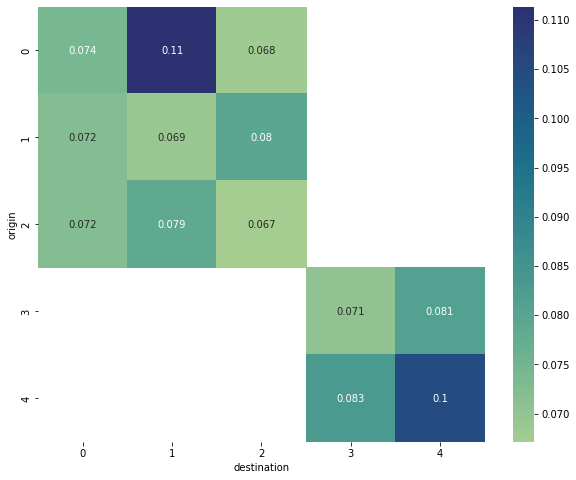

In [22]:
sns.heatmap(((unmade_trips_OD)/df_od), annot = True, cmap="crest")

In [23]:
((unmade_trips_OD)/df_od)

destination,0,1,2,3,4
origin,,,,,
0,0.074074,0.111332,0.068041,NaN,NaN
1,0.072356,0.069022,0.079503,NaN,NaN
2,0.072372,0.078633,0.067126,NaN,NaN
3,NaN,NaN,NaN,0.070528,0.081006
4,NaN,NaN,NaN,0.083045,0.104712


In [24]:
max_destination = ((unmade_trips_OD)/df_od).max().idxmax()


In [25]:
max_origin =((unmade_trips_OD)/df_od).max(axis = 1).idxmax()

In [26]:
print('from origin {} to destination {} is the biggest not_done trip percent'.format(max_origin,max_destination))

from origin 0 to destination 1 is the biggest not_done trip percent


5)

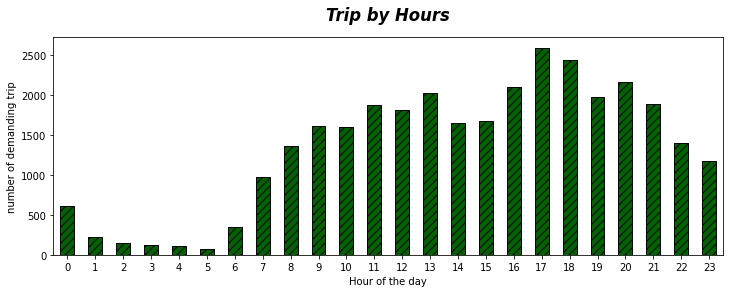

In [27]:

fig, axs = plt.subplots(figsize=(12, 4))

df_3.groupby(df_3.index.hour)["destination"].sum().plot(
     kind='bar', rot=0,color='darkgreen', edgecolor='k', hatch='///', ax=axs)
plt.title('Trip by Hours',fontsize = 16.5,fontstyle='italic', color = 'k',fontweight='bold',y = 1.05 )
plt.xlabel("Hour of the day");  # custom x label using Matplotlib
plt.ylabel("number of demanding trip");

# passenger behavier analysis

Fitting 5 distributions: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
beta,9.331638e-09,3.296630e+03,-749842.085966,inf,0.097963,5.246135e-219
burr,9.484967e-09,2.900789e+03,-749415.693962,inf,0.120328,0.000000e+00
norm,9.838463e-09,5.538373e+03,-748478.698131,inf,0.135445,0.000000e+00
lognorm,1.567041e-08,3.021718e+03,-736290.314232,inf,0.702647,0.000000e+00
gamma,1.741110e-08,5.263158e+06,-733534.462126,2.883857,0.984190,0.000000e+00


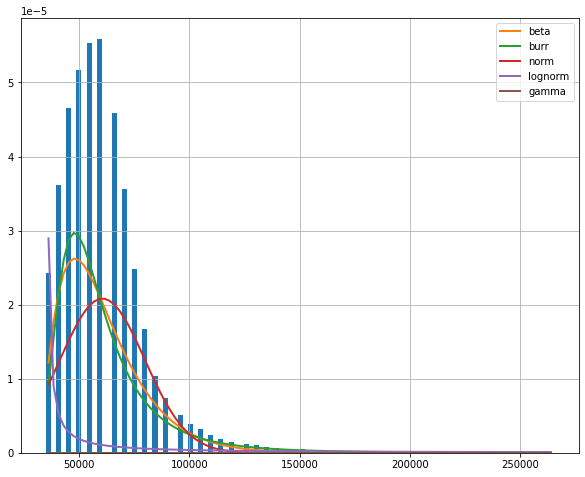

In [28]:
#checking normal condition for our data
f = Fitter(df_3.price,distributions=['gamma','lognorm',"beta","burr","norm"])
f.fit()
f.summary()

In [29]:
print('price is not normal, so we try to fix it')

price is not normal, so we try to fix it


In [30]:
# we must normalize our price data for statistical testting
N_price ,lmbda = stats.boxcox(df_3.price.values)
df_3['Norm_price'] = N_price


In [31]:
#6
data_status_2 = df_3.loc[df_3.status == 2]['Norm_price']
data_status_1_3_4 = df_3.loc[(df_3.status > 0)&(df_3.status != 2)]['Norm_price']

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,6.117540e+07,-1006.494900,27786.217067,inf,0.092994,2.377221e-21
gamma,6.117840e+07,-1005.081068,27794.282254,inf,0.093450,1.479503e-21
beta,6.121272e+07,-1003.444144,27803.769060,inf,0.096316,7.114743e-23
burr,6.684024e+07,-972.385345,28048.006723,inf,0.418382,0.000000e+00
lognorm,7.185769e+07,-940.083835,28241.083597,inf,0.335970,4.825263e-280


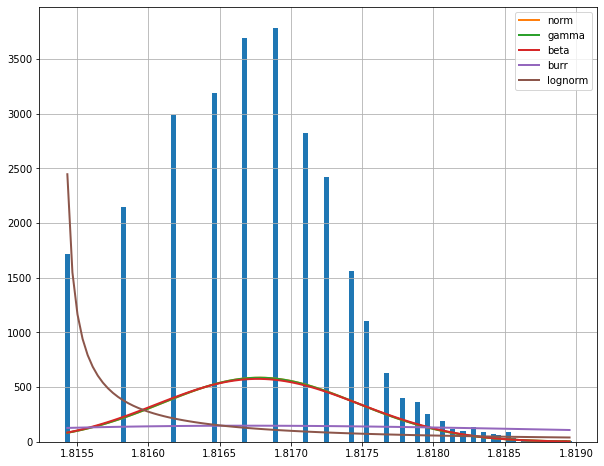

In [32]:
#checking normal condition in both groups
f = Fitter(data_status_2,distributions=['gamma','lognorm',"beta","burr","norm"])
f.fit()
f.summary()


Fitting 5 distributions: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,5.001664e+07,-911.362188,111459.257808,inf,0.089841,9.308818e-96
gamma,5.002304e+07,-911.897450,111470.510859,inf,0.090752,1.053005e-97
beta,5.005196e+07,-889.408633,111487.868825,inf,0.093692,4.049068e-104
lognorm,5.010142e+07,-927.841607,111491.754290,inf,0.105402,1.005055e-131
burr,5.527552e+07,-968.341922,112834.940099,inf,0.420673,0.000000e+00


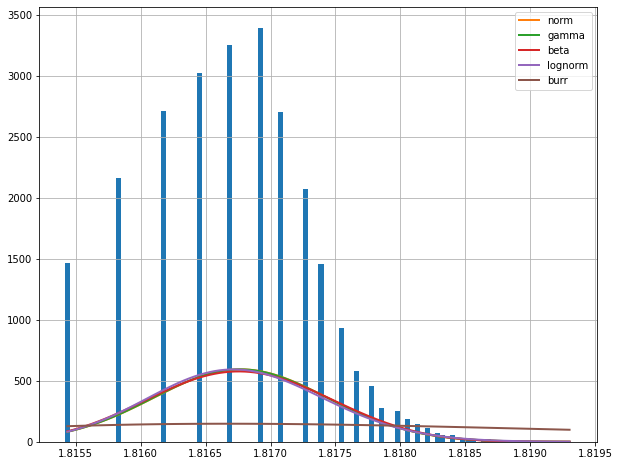

In [33]:
f = Fitter(data_status_1_3_4,distributions=['gamma','lognorm',"beta","burr","norm"])
f.fit()
f.summary()

6)


In [34]:
# we use T-test_ind, conditions for testting have been met(normal ditribution and eqaul var)
# we use Two-way test so we must check with 0.025

stat, p = ttest_ind(data_status_2,data_status_1_3_4 ,equal_var = False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.025:
    print('p_value is grater than 0.025 so H0 is accepted and there is no relationship between rejected trips by passengers and price')
else:
    print('there is a corrolation between rejected trip by passengers and  price')

stat=0.778, p=0.436
p_value is grater than 0.025 so H0 is accepted and there is no relationship between rejected trips by passengers and price


7)

In [35]:

data_status_3_4 = df_3.loc[(df_3.status == 3)|(df_3.status == 4)]['Norm_price']
data_status_1_2= df_3.loc[(df_3.status == 1)|(df_3.status == 2)]['Norm_price']

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,6.601454e+07,-1007.435418,11293.077831,inf,0.094011,2.787691e-08
gamma,6.602202e+07,-1006.604047,11300.118801,inf,0.094901,1.975699e-08
beta,6.603124e+07,-1002.002542,11307.186479,inf,0.093739,3.094564e-08
burr,7.205588e+07,-973.311727,11396.072049,inf,0.423913,1.860639e-166
lognorm,7.825858e+07,-945.063935,11473.209371,inf,0.328991,1.188267e-98


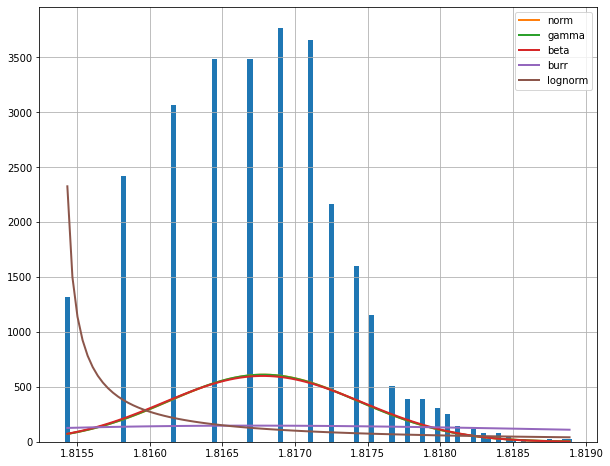

In [36]:
#checking normal condition in both groups
f = Fitter(data_status_3_4,distributions=['gamma','lognorm',"beta","burr","norm"])
f.fit()
f.summary()

Fitting 5 distributions: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,4.988664e+07,-913.933523,123996.579796,inf,0.090582,6.747427e-110
gamma,4.989105e+07,-913.624108,124007.572706,inf,0.091213,1.975353e-111
beta,4.992411e+07,-894.530365,124027.362352,inf,0.094535,1.112697e-119
lognorm,5.006453e+07,-952.959794,124060.781829,inf,0.114114,2.416541e-174
burr,5.511863e+07,-968.458569,125544.684789,inf,0.421069,0.000000e+00


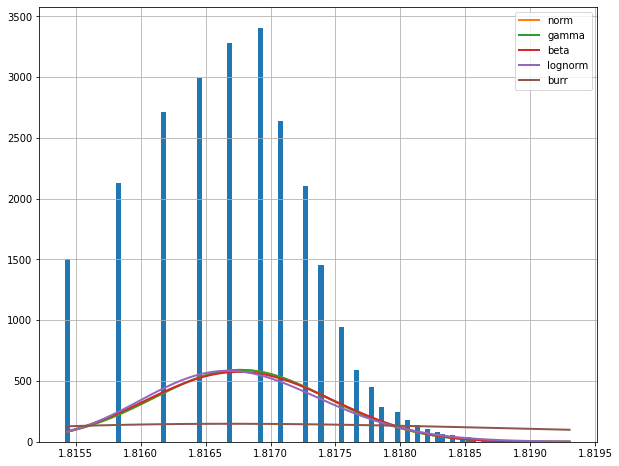

In [37]:

f = Fitter(data_status_1_2,distributions=['gamma','lognorm',"beta","burr","norm"])
f.fit()
f.summary()

In [38]:
# we use T-test_ind, conditions for testting have been met(normal ditribution and eqaul var)
# we use Two-way test so we must check with 0.025

stat, p = ttest_ind(data_status_3_4,data_status_1_2 ,equal_var = False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.025:
    print('p_value is grater than 0.025 so H0 is accepted and there is no relationship between rejected trips by driver and price')
else:
    print('there is a corrolation between rejected trip by driver and  price')

stat=0.603, p=0.547
p_value is grater than 0.025 so H0 is accepted and there is no relationship between rejected trips by driver and price


8)

In [39]:
df_3['price_check_time']=df_3.index
df_3['price_check_time'] = pd.to_datetime(df_3['price_check_time'])
df_3['hour'] = df_3['price_check_time'].dt.hour
#df_3.drop(['houer'], axis=1)


In [40]:
peak_data = df_3.loc[(((df_3.hour >= 6)&(df_3.hour <= 7))|((df_3.hour >= 16))&(df_3.hour <= 18))&(df_3.status>=3)]['Norm_price']
no_peak_data = df_3.loc[((df_3.hour < 6)|((df_3.hour > 7)&(df_3.hour < 16))|((df_3.hour > 19)&(df_3.hour <= 23)))&(df_3.status>=3)]['Norm_price']

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,9.530233e+07,-1097.168149,3566.099909,inf,0.106157,3.424013e-03
beta,9.531101e+07,-1096.436065,3577.387766,inf,0.104637,4.101535e-03
lognorm,9.533291e+07,-1097.366972,3571.820649,inf,0.103684,4.587124e-03
gamma,9.536940e+07,-1097.925480,3571.927411,inf,0.112505,1.565972e-03
burr,1.019355e+08,-980.588624,3596.135129,inf,0.434123,2.525521e-48


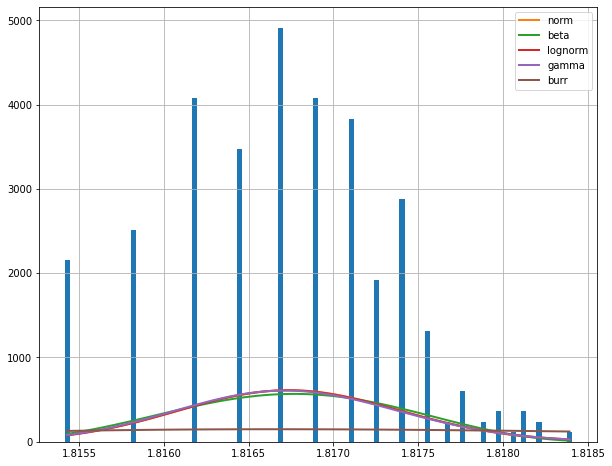

In [41]:
f = Fitter(peak_data,distributions=['gamma','lognorm',"beta","burr","norm"])
f.fit()
f.summary()

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,6.668743e+07,-1009.277048,7418.077027,inf,0.098626,7.028102e-06
gamma,6.672105e+07,-1012.554914,7424.863127,inf,0.103288,2.084918e-06
beta,6.672506e+07,-1010.937378,7431.364632,inf,0.103681,1.877525e-06
burr,7.293806e+07,-973.695676,7488.432869,inf,0.425922,4.816614e-106
lognorm,8.013892e+07,-945.933243,7542.320675,inf,0.330377,7.713815e-63


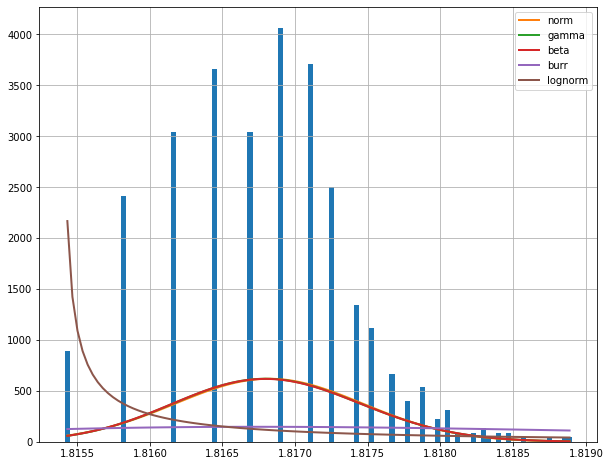

In [42]:
f = Fitter(no_peak_data,distributions=['gamma','lognorm',"beta","burr","norm"])
f.fit()
f.summary()

In [43]:
# we use T-test_ind, conditions for testting have been met(normal ditribution and eqaul var)
# we use Two-way test so we must check with 0.025

stat, p = ttest_ind(peak_data,no_peak_data ,equal_var = False)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.025:
    print('p_value is grater than 0.025 so H0 is accepted and there is no relationship between rejected trips by driver and peck or no_peck time')
else:
    print('there is a corrolation between rejected trip by driver and  peck or no_peck time')

stat=-1.673, p=0.095
p_value is grater than 0.025 so H0 is accepted and there is no relationship between rejected trips by driver and peck or no_peck time


9)

Text(0, 0.5, 'price')

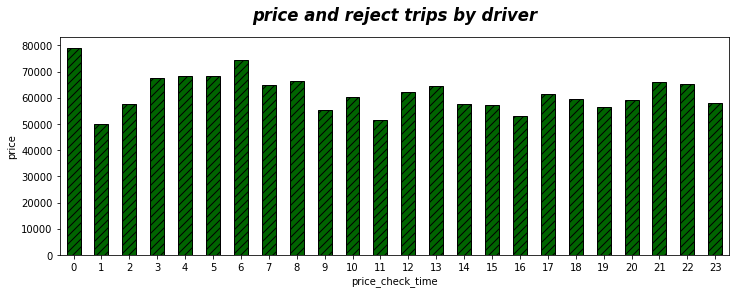

In [44]:
df_groupby = df_3[df_3['status'] == 3].groupby([df_3[df_3['status'] == 3].index.hour]).price.mean()

df_groupby.plot(figsize=(12,4), kind='bar', rot=0, color='darkgreen', edgecolor='k', hatch='///' 
                         )
plt.title('price and reject trips by driver',fontsize = 16.5,fontstyle='italic', color = 'k',fontweight='bold',y = 1.05 )
plt.ylabel('price')

Text(0.5, 1.05, ' mean price and reject trips by driver')

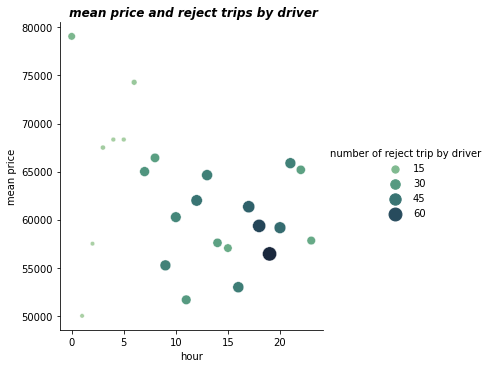

In [45]:
df_groupby2=df_3[df_3['status'] == 3].groupby([df_3[df_3['status'] == 3].index.hour]).hour.count()
dict = {'mean price':list(df_groupby) , 'number of reject trip by driver':list(df_groupby2) , 'hour': list(df_groupby2.index)} 
    
df = pd.DataFrame(dict)
    
figsize=(12,4)
sns.relplot(
    data=df, x="hour", y="mean price", hue="number of reject trip by driver",size="number of reject trip by driver", palette="ch:r=-.5,l=.75",sizes=(20, 200), 
)
plt.title(' mean price and reject trips by driver',fontsize = 12,fontstyle='italic', color = 'k',fontweight='bold',y = 1.05 )


# Regression(optional)

In [46]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split

x = df_3[['passenger','origin','destination','subsidy','distance','expected_duration']]
y = df_3['price']
train_x, test_x, train_y, test_y = train_test_split(x, y,random_state = 2,test_size=0.3)


In [47]:
regr = linear_model.LinearRegression()
regr.fit(train_x,train_y)
y_pred = regr.predict(test_x)
print("accuracy: "+ str(regr.score(test_x,test_y)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(test_y,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(test_y,y_pred)))
R2 = r2_score(test_y,y_pred)
print('R Squared: {}'.format(R2))
n=test_x.shape[0]
p=test_x.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 64.89121171584867%
Mean absolute error: 8004.278780984797
Mean squared error: 132954211.65565453
R Squared: 0.6489121171584866
Adjusted R Squared: 0.6486882947162824


In [48]:
las_reg = linear_model.Lasso()
las_reg.fit(train_x,train_y)
y_pred = las_reg.predict(test_x)
print("accuracy: "+ str(las_reg.score(test_x,test_y)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(test_y,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(test_y,y_pred)))
R2 = r2_score(test_y,y_pred)
print('R Squared: {}'.format(R2))
n=test_x.shape[0]
p=test_x.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 64.89117891109461%
Mean absolute error: 8004.239039841959
Mean squared error: 132954335.88467023
R Squared: 0.6489117891109462
Adjusted R Squared: 0.648687966459608


In [49]:
rig_reg = linear_model.Ridge()
rig_reg.fit(train_x,train_y)
y_pred = rig_reg.predict(test_x)
print("accuracy: "+ str(rig_reg.score(test_x,test_y)*100) + "%")
print("Mean absolute error: {}".format(mean_absolute_error(test_y,y_pred)))
print("Mean squared error: {}".format(mean_squared_error(test_y,y_pred)))
R2 = r2_score(test_y,y_pred)
print('R Squared: {}'.format(R2))
n=test_x.shape[0]
p=test_x.shape[1] - 1

adj_rsquared = 1 - (1 - R2) * ((n - 1)/(n-p-1))
print('Adjusted R Squared: {}'.format(adj_rsquared))

accuracy: 64.89121587865263%
Mean absolute error: 8004.274618813902
Mean squared error: 132954195.89144427
R Squared: 0.6489121587865263
Adjusted R Squared: 0.6486883363708604
